# DECODE reproducability project
This notebook will guide you through the process of training, fitting and evaluation a DECODE model. The code used in this notebook has been adapted from the notebooks provided by the TuragaLab, which can be found at https://github.com/TuragaLab/DECODE.

## Training a network

In [187]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [191]:
#GPU settings
device = 'cuda'
device_ix = 0
threads = 4  
worker = 4
torch.set_num_threads(threads)

#Provide a calibration file
calib_file = 'myExamples/Model3D/Training/flat-cspline-calib-1-nobg1_3Dcorr.mat'

In [192]:
#Set parameters
decode.utils.param_io.copy_reference_param('') #copy default parameters
param = decode.utils.param_io.load_params('param_friendly.yaml')
param.Hardware.device = device
param.Hardware.device_ix = device_ix
param.Hardware.device_simulation = device
param.Hardware.torch_threads = threads
param.Hardware.num_worker_train = worker

param.Camera.baseline = 98.6
param.Camera.e_per_adu = 5.0
param.Camera.em_gain = 10
param.Camera.px_size =[100.0, 100.0]
param.Camera.qe = 1.0                
param.Camera.read_sigma = 58.8
param.Camera.spur_noise = 0.0015

param.Simulation.bg_uniform = [20.0, 200.0]           
param.Simulation.emitter_av = 25                      
param.Simulation.emitter_extent[2] = [-100, 100]   
param.Simulation.intensity_mu_sig = [700.0, 3000.0]  
param.Simulation.lifetime_avg = 1.   

param.InOut.calibration_file = calib_file
param.InOut.experiment_out = ''

In [193]:
#Setup the simulation
simulator, sim_test = decode.neuralfitter.train.live_engine.setup_random_simulation(param)
camera = decode.simulation.camera.Photon2Camera.parse(param)
param = decode.utils.param_io.autoset_scaling(param)

In [194]:
#Sample example frames
tar_em, sim_frames, bg_frames = simulator.sample()
sim_frames = sim_frames.cpu()

frame_path = 'myExamples/Model3D/Validation/tirf-flatdm-1.tif'
data_frames = decode.utils.frames_io.load_tif(frame_path).cpu()

#Cropping of image, because of computational limits
data_frames = torch.split(data_frames, 128, 1)[3]
data_frames = torch.split(data_frames, 128, 2)[3]

data_frames = camera.backward(data_frames, device='cpu')

print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Average value, simulation: 119.0, real data: 101.0


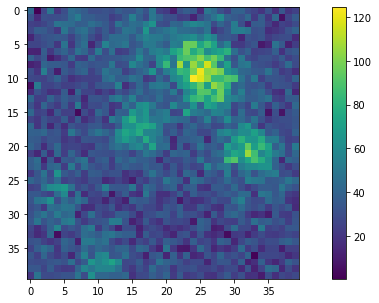

In [195]:
#Plot example frame
plt.figure(figsize=(12,5))

plt.imshow(sim_frames[np.random.randint(0,len(sim_frames))])
plt.colorbar()

In [196]:
#Save the parameters
param_out_path = 'notebook_example.yaml'
decode.utils.param_io.save_params(param_out_path, param)  

### Start the Actual Training of the Model
For stability, it is recommended to start the actual training of the model in the terminal using the following command:

    python -m decode.neuralfitter.train.live_engine -p notebook_example.yaml  # change path if you modified it
    
We can keep track of the training performance in Tensorboard using:

    tensorboard --samples_per_plugin images=100 --port=6006 --logdir=runs

## Fit the trained model on biological data

In [197]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [198]:
#GPU settings
device = 'cuda'
threads = 4
worker = 4
torch.set_num_threads(threads)

In [200]:
#Specify paths to parameter, model and image files
param_path = 'myExamples/Model3D/Training/param_run.yaml'
model_path = 'myExamples/Model3D/Training/2021-03-29_12-33-37_TUD1001719/2021-03-29_12-33-37_TUD1001719_0.pt'
frame_path = 'myExamples/Model3D/Validation/tirf-flatdm-1.tif'

#Camera settings
meta = {
    'Camera': {
        'baseline': 398.6,
        'e_per_adu': 5.0,
        'em_gain': 10.0,
        'spur_noise': 0.0015
    }
}

In [202]:
#Load parameters and model
param = decode.utils.param_io.load_params(param_path)
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                            input_file=model_path,
                                            output_file=None).load_init(device=device)

param = decode.utils.param_io.autofill_dict(meta['Camera'], param.to_dict(), mode_missing='include')
param = decode.utils.param_io.RecursiveNamespace(**param)

Model instantiated.
Model SHA-1 hash: 9399057301dd775d24039d7a2ef55c77647fcddb
Loaded pretrained model: myExamples\Model3D\Training\2021-03-29_12-33-37_TUD1001719\2021-03-29_12-33-37_TUD1001719_0.pt


In [203]:
#Load the image
frames = decode.utils.frames_io.load_tif(frame_path)

#Cropping because of computational limits
frames = torch.split(frames, 128, 1)[3]
frames = torch.split(frames, 128, 2)[3]

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.device = 'cpu'

In [204]:
#Helper functions for frame processing
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.frame_processing.Mirror2D(dims=-1),
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.unsqueeze(1).size(), frame_proc.forward)  # frame size after processing
frame_extent = ((-0.5, size_procced[-2] - 0.5), (-0.5, size_procced[-1] - 0.5))

post_proc = decode.neuralfitter.utils.processing.TransformSequence([
    
    decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),
    
    decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                          yextent=frame_extent[1],
                                                          img_shape=size_procced[-2:]),
    
    decode.neuralfitter.post_processing.NMSPostProcessing(raw_th=0.1,
                                                          xy_unit='px', 
                                                          px_size=param.Camera.px_size)
    
    
])

In [205]:
#Have the model predict on the data
infer = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
                                  frame_proc=frame_proc, post_proc=post_proc,
                                  device=device, num_workers=0, pin_memory=False, batch_size=1)

emitter = infer.forward(frames)

100%|██████████| 2084/2084 [00:25<00:00, 81.13it/s]


EmitterSet
::num emitters: 17259
::xy unit: px
::px size: tensor([127., 117.])
::frame range: 0 - 2083
::spanned volume: [-4.9211702e-01 -3.7414595e-01 -7.2630878e+02] - [127.44424 127.46406 310.98874]


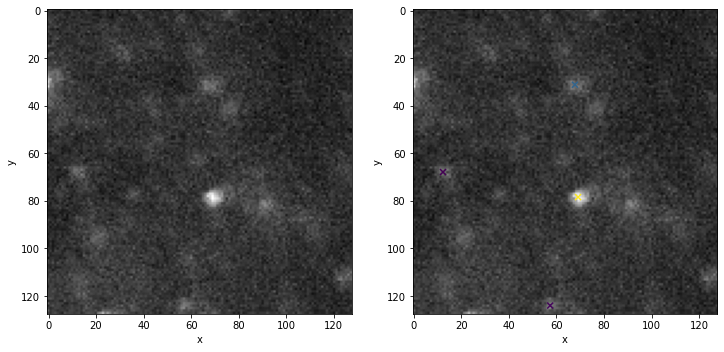

In [206]:
#Check the output emitterset
print(emitter)

#Plot a random frame
random_ix = torch.randint(frames.size(0), size=(1, )).item()
em_subset = emitter.get_subset_frame(random_ix, random_ix)

plt.figure(figsize=(12, 6))
plt.subplot(121)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[random_ix])).plot()
plt.subplot(122)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]]), 
                           pos_out=em_subset.xyz_px, phot_out=em_subset.prob).plot()
plt.show()

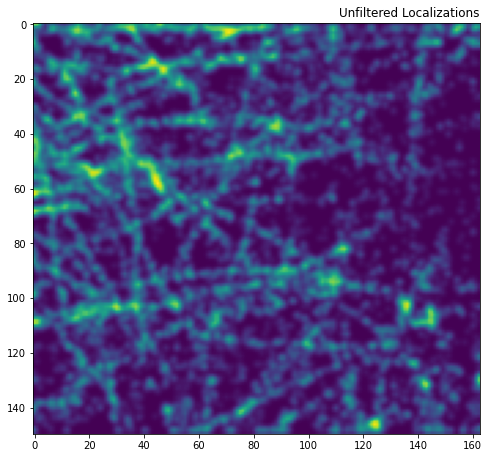

In [207]:
#Make a render of the predicted figure
import decode.renderer
plt.figure(figsize=(8, 8))
decode.renderer.renderer.Renderer2D(px_size=100., sigma_blur=100., clip_percentile=97.).render(emitter, cmap = 'viridis')

plt.title('Unfiltered Localizations', loc='right')
plt.show()

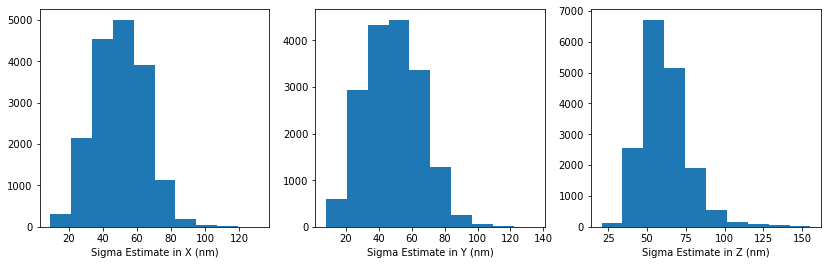

In [208]:
#Plot uncertainty estimates
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.hist(emitter.xyz_sig_nm[:, 0].numpy())
plt.xlabel('Sigma Estimate in X (nm)')

plt.subplot(132)
plt.hist(emitter.xyz_sig_nm[:, 1].numpy())
plt.xlabel('Sigma Estimate in Y (nm)')

plt.subplot(133)
plt.hist(emitter.xyz_sig_nm[:, 2].numpy())
plt.xlabel('Sigma Estimate in Z (nm)')

plt.show()

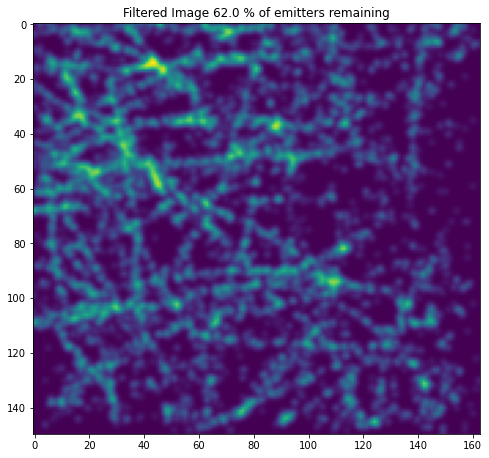

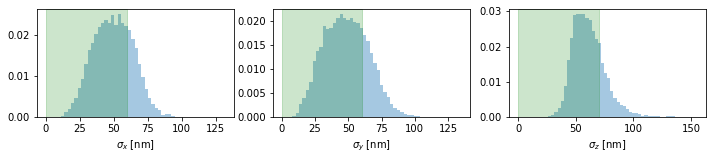

In [210]:
import seaborn as sns

#Filter out emitters based on their sigma
sigma_x_high_threshold = 60 
sigma_y_high_threshold = 60 
sigma_z_high_threshold = 70 

em_sub = emitter[(emitter.xyz_sig_nm[:, 0] <= sigma_x_high_threshold) * (emitter.xyz_sig_nm[:, 1] <= sigma_x_high_threshold) * (emitter.xyz_sig_nm[:, 2] <= sigma_z_high_threshold)]

plt.figure(figsize=(8, 8))
decode.renderer.renderer.Renderer2D(px_size=100., sigma_blur=100., clip_percentile=97.).render(em_sub, cmap = 'viridis')
plt.title(f'Filtered Image {np.round(100*len(em_sub)/len(emitter))} % of emitters remaining')

plt.show()

plt.fig, ax = plt.subplots(1, 3, figsize=(12, 2))
sns.distplot(emitter.xyz_sig_nm[:, 0], bins=50, norm_hist=True, kde=False, ax=ax[0])
ax[0].axvspan(0., sigma_x_high_threshold, alpha=0.2, color='green')
ax[0].set_xlabel(r'$\sigma_x$ [nm]')

sns.distplot(emitter.xyz_sig_nm[:, 1], bins=50, norm_hist=True, kde=False, ax=ax[1])
ax[1].axvspan(0., sigma_y_high_threshold, alpha=0.2, color='green')
ax[1].set_xlabel(r'$\sigma_y$ [nm]')

sns.distplot(emitter.xyz_sig_nm[:, 2], bins=50, norm_hist=True, kde=False, ax=ax[2])
ax[2].axvspan(0., sigma_z_high_threshold, alpha=0.2, color='green')
ax[2].set_xlabel(r'$\sigma_z$ [nm]')

plt.show()

## Evaluate the trained model on simulated data

In [211]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [212]:
#GPU settings
device = 'cuda' 
threads = 4  
worker = 4 
torch.set_num_threads(threads)

In [213]:
#Specify parameter and model
param_path = 'myExamples/Model3D/Validation/param_run.yaml'
model_path = 'myExamples/Model3D/Validation/model_0.pt'

#Specify camera parameters
meta = {
    'Camera': {
        'baseline': 98.6,
        'e_per_adu': 5.0,
        'em_gain': 10.0,
        'spur_noise': 0.0015
    }
}

In [214]:
#Load parameters and model
param = decode.utils.param_io.load_params(param_path)
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                            input_file=model_path,
                                            output_file=None).load_init(device=device)

param = decode.utils.param_io.autofill_dict(meta['Camera'], param.to_dict(), mode_missing='include')
param = decode.utils.param_io.RecursiveNamespace(**param)

Model instantiated.
Model SHA-1 hash: 25505c373e0d33046f431a898ee40b2f74a230b4
Loaded pretrained model: myExamples\Model3D\Validation\model_0.pt


In [215]:
#Specify background and point spread function
param.InOut.calibration_file='myExamples/Model3D/Training/flat-cspline-calib-1-nobg1_3Dcorr.mat'

bg = decode.simulation.background.UniformBackground.parse(param)

psf = decode.utils.calibration_io.SMAPSplineCoefficient(
         calib_file=param.InOut.calibration_file).init_spline(
         xextent=param.Simulation.psf_extent[0],
         yextent=param.Simulation.psf_extent[1],
         img_shape=param.Simulation.img_size,
         cuda_kernel=True if param.Hardware.device_simulation[:4] == 'cuda' else False,
         roi_size=param.Simulation.roi_size,
         roi_auto_center=param.Simulation.roi_auto_center
     )

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.device = 'cpu'

In [216]:
# Helper function for frame processing
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

In [217]:
#The evaluation loop: generate random data for a range of distances
jaccard_avg = []
rmse_x_avg = []
rmse_y_avg = []
rmse_z_avg = []
distance_avg = []
crlb_x_avg = []
crlb_y_avg = []
crlb_z_avg = []
sigma_x_avg = []
sigma_y_avg = []
sigma_z_avg = []

#Specify maximum distance (in pixels) and amount of trials per distance
maxdistance = 15
ntrials = 100

for i in range(maxdistance * 10 + 1):
    jaccard = []
    rmse_x = []
    rmse_y = []
    rmse_z = []
    distance = []
    crlb = []
    sigma_x = []
    sigma_y = []
    sigma_z = []    
    for j in range(ntrials):
        #Generate random vector with distance i
        x = np.random.rand((2)) * 2 - 1 #generate random vector around zero
        length = np.sqrt(sum(x ** 2))
        x = x / length #normalize
        x = x * i / 10
        x = ([20., 20.] + x).tolist()
        x.append(0.)
        
        #Specify emitterset
        em_ref = decode.EmitterSet(
            xyz=torch.tensor([x, [20., 20., 0.]]),
            phot=torch.tensor([5000, 5000]),
            frame_ix=torch.tensor([0, 0]),
            xy_unit='px', 
            px_size=(100., 100.), 
            bg=torch.tensor([0,0]))
        
        #Calculate crlb
        em_ref.populate_crlb(psf)
        crlb.append(em_ref.xyz_cr_nm)
        
        #Generate data
        simulation_test = decode.simulation.simulator.Simulation(psf=psf, em_sampler=em_ref, background=bg,
                                                                  noise=None, frame_range=None)
        frames, bg_frames = simulation_test.forward(em_ref)
        size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.unsqueeze(1).size(), frame_proc.forward)  # frame size after processing
        frame_extent = ((-0.5, size_procced[-2] - 0.5), (-0.5, size_procced[-1] - 0.5))
        post_proc = decode.neuralfitter.utils.processing.TransformSequence([

            decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),

            decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                              yextent=frame_extent[1],
                                                              img_shape=size_procced[-2:]),

            decode.neuralfitter.post_processing.NMSPostProcessing(raw_th=0.1,
                                                              xy_unit='px', 
                                                              px_size=param.Camera.px_size)


        ])
        
        #Infer emitters
        infer = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
            frame_proc=frame_proc, post_proc=post_proc,
            device=device, num_workers=0, pin_memory=False, batch_size=1)
        em_pred = infer.forward(frames)
        
        #Match predicted emitters
        matcher = decode.evaluation.match_emittersets.GreedyHungarianMatching(match_dims=3, dist_lat=2500, dist_ax=5000.)
        tp, fp, fn, tp_match = matcher.forward(em_pred, em_ref)
        
        #Calculate Jaccard index
        jac = (len(tp) / (len(em_pred) + len(em_ref) - len(tp)))
        jaccard.append(jac)
        
        #Calculate RMSE
        if jac == 1:
            rmse = ((tp.xyz_nm[0] - tp_match.xyz_nm[0]) ** 2).sqrt()
            
            rmse_x.append(rmse[0])
            rmse_y.append(rmse[1])
            rmse_z.append(rmse[2]) 
            
            sigma_x.append(torch.mean(em_pred.xyz_sig_nm, 0)[0])
            sigma_y.append(torch.mean(em_pred.xyz_sig_nm, 0)[1])
            sigma_z.append(torch.mean(em_pred.xyz_sig_nm, 0)[2])

        distance.append(sum(abs(em_ref.xyz_nm[0] - em_ref.xyz_nm[1]) ** 2).sqrt())
    
    #Calculate averages
    jaccard_avg.append(sum(jaccard)/len(jaccard))
    if len(rmse_x) != 0:
        rmse_x_avg.append(sum(rmse_x)/len(rmse_x))
        rmse_y_avg.append(sum(rmse_y)/len(rmse_y))
        rmse_z_avg.append(sum(rmse_z)/len(rmse_z))
        sigma_x_avg.append(sum(sigma_x)/len(sigma_x))
        sigma_y_avg.append(sum(sigma_y)/len(sigma_y))
        sigma_z_avg.append(sum(sigma_z)/len(sigma_z))
    else:
        rmse_x_avg.append(0)
        rmse_y_avg.append(0)
        rmse_z_avg.append(0)
        sigma_x_avg.append(0)
        sigma_y_avg.append(0)
        sigma_z_avg.append(0)
    distance_avg.append(sum(distance)/len(distance))
    crlb_x_avg.append((sum(crlb)/len(crlb))[0][0])
    crlb_y_avg.append((sum(crlb)/len(crlb))[0][1])
    crlb_z_avg.append((sum(crlb)/len(crlb))[0][2])


100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


100%|██████████| 1/1 [00:00<00:00, 71.47it/s]


100%|██████████| 1/1 [00:00<00:00, 66.85it/s]


100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


100%|██████████| 1/1 [00:00<00:00, 100.55it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 66.84it/s]


100%|██████████| 1/1 [00:00<00:00, 91.41it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 91.16it/s]


100%|██████████| 1/1 [00:00<00:00, 100.26it/s]


100%|██████████| 1/1 [00:00<00:00, 83.55it/s]


100%|██████████| 1/1 [00:00<00:00, 90.91it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 83.59it/s]


100%|██████████| 1/1 [00:00<00:00, 91.16it/s]


100%|██████████| 1/1 [00:00<00:00, 90.95it/s]


100%|██████████| 1/1 [00:00<00:00, 66.71it/s]


100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 62.67it/s]


100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


100%|██████████| 1/1 [00:00<00:00, 100.26it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.13it/s]


100%|██████████| 1/1 [00:00<00:00, 82.84it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.38it/s]


100%|██████████| 1/1 [00:00<00:00, 90.91it/s]


100%|██████████| 1/1 [00:00<00:00, 83.75it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


100%|██████████| 1/1 [00:00<00:00, 100.26it/s]


100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


100%|██████████| 1/1 [00:00<00:00, 83.55it/s]


100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 77.30it/s]


100%|██████████| 1/1 [00:00<00:00, 62.66it/s]


100%|██████████| 1/1 [00:00<00:00, 90.77it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.16it/s]


100%|██████████| 1/1 [00:00<00:00, 83.55it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.64it/s]


100%|██████████| 1/1 [00:00<00:00, 99.98it/s]


100%|██████████| 1/1 [00:00<00:00, 83.54it/s]


100%|██████████| 1/1 [00:00<00:00, 91.16it/s]


100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 90.86it/s]


100%|██████████| 1/1 [00:00<00:00, 77.31it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 83.55it/s]


100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 66.84it/s]


100%|██████████| 1/1 [00:00<00:00, 100.26it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 83.54it/s]


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


100%|██████████| 1/1 [00:00<00:00, 77.05it/s]


100%|██████████| 1/1 [00:00<00:00, 83.53it/s]


100%|██████████| 1/1 [00:00<00:00, 91.14it/s]


100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


100%|██████████| 1/1 [00:00<00:00, 91.14it/s]


100%|██████████| 1/1 [00:00<00:00, 83.36it/s]


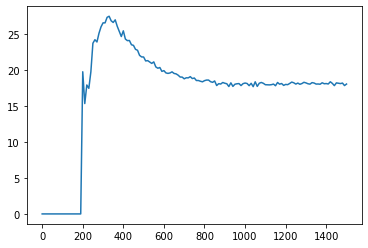

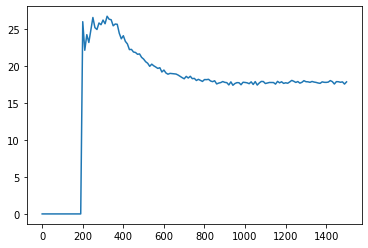

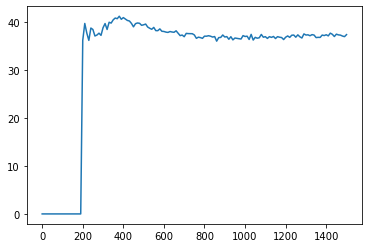

In [218]:
#Plot uncertainty estimates
plt.figure()
plt.plot(distance_avg, sigma_x_avg)
plt.figure()
plt.plot(distance_avg, sigma_y_avg)
plt.figure()
plt.plot(distance_avg, sigma_z_avg)

Text(0.5, 0, 'Distance (nm)')

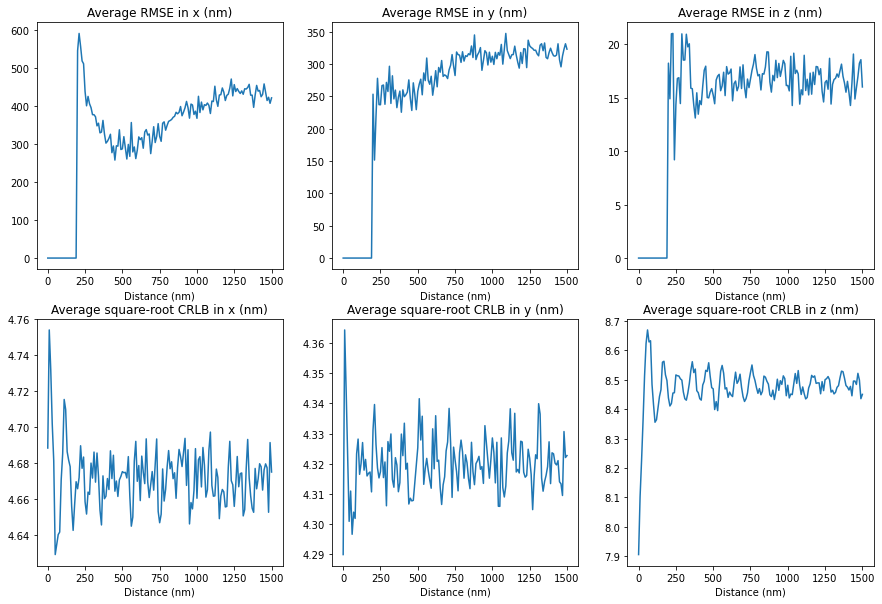

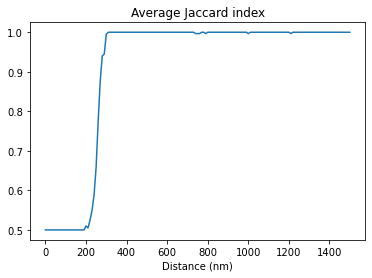

In [219]:
#Visualize the performance in graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0][0].plot(distance_avg, rmse_x_avg)
axes[0][0].set_title('Average RMSE in x (nm)')
axes[0][0].set_xlabel('Distance (nm)')
axes[0][1].plot(distance_avg, rmse_y_avg)
axes[0][1].set_title('Average RMSE in y (nm)')
axes[0][1].set_xlabel('Distance (nm)')
axes[0][2].plot(distance_avg, rmse_z_avg)
axes[0][2].set_title('Average RMSE in z (nm)')
axes[0][2].set_xlabel('Distance (nm)')
axes[1][0].plot(distance_avg, np.sqrt(np.array(crlb_x_avg)))
axes[1][0].set_title('Average square-root CRLB in x (nm)')
axes[1][0].set_xlabel('Distance (nm)')
axes[1][1].plot(distance_avg, np.sqrt(np.array(crlb_y_avg)))
axes[1][1].set_title('Average square-root CRLB in y (nm)')
axes[1][1].set_xlabel('Distance (nm)')
axes[1][2].plot(distance_avg, np.sqrt(np.array(crlb_z_avg)))
axes[1][2].set_title('Average square-root CRLB in z (nm)')
axes[1][2].set_xlabel('Distance (nm)')

plt.figure()
plt.title('Average Jaccard index')
plt.plot(distance_avg, jaccard_avg)
plt.xlabel('Distance (nm)')

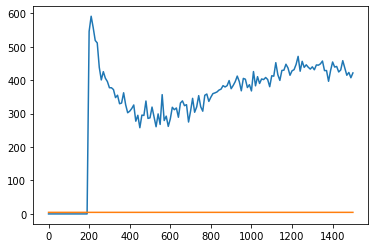

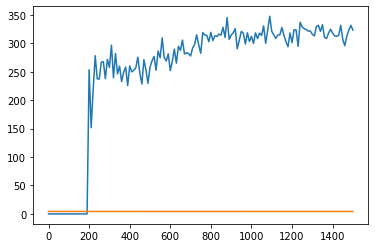

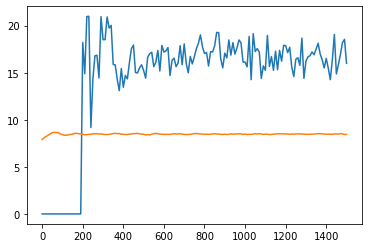

In [220]:
#Compare the RMSE and CRLB
plt.figure()
plt.plot(distance_avg, rmse_x_avg)
plt.plot(distance_avg, np.sqrt(np.array(crlb_x_avg)))
plt.figure()
plt.plot(distance_avg, rmse_y_avg)
plt.plot(distance_avg, np.sqrt(np.array(crlb_y_avg)))
plt.figure()
plt.plot(distance_avg, rmse_z_avg)
plt.plot(distance_avg, np.sqrt(np.array(crlb_z_avg)))